In [1]:
using HDF5
using Plots
using LadderDGA
using Suppressor
using Logging

#path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
#path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config2.toml"

empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317


In [2]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2694, χLoc_ch(16:26) = 0.093 
└ sum χupup check (normal/improved sum, tail sub sum, expected): 0.1811947008638526 ?≈? 0.18119470086385256 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2696, χLoc_ch(16:26) = 0.0932 
└ sum χupup check (normal/improved sum, tail sub sum, expected): 0.1813620894231569 ?≈? 0.1813620894231569 ?≈? 0.25"


In [3]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc,tmpLoc,Σ_ladderLoc_ω = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

bubbleLoc2 = calc_bubble(νGrid2, GImp_fft2, qGridLoc, mP2, sP2);
locQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
locQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
Σ_ladderLoc2,tmpLoc2,Σ_ladderLoc_ω2 = calc_Σ(locQ_sp2, locQ_ch2, bubbleLoc2, GImp_fft2, FUpDo,
                     qGridLoc, sumHelper_f2, mP2, sP2)
Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP2.n * mP2.U/2.0;

# Σ_ladderLoc_ω[20,1,:] 

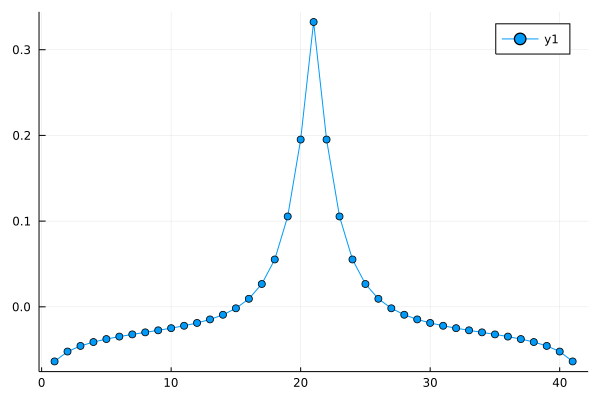

In [4]:
plot(real(locQ_ch.χ),markershape=:circle)

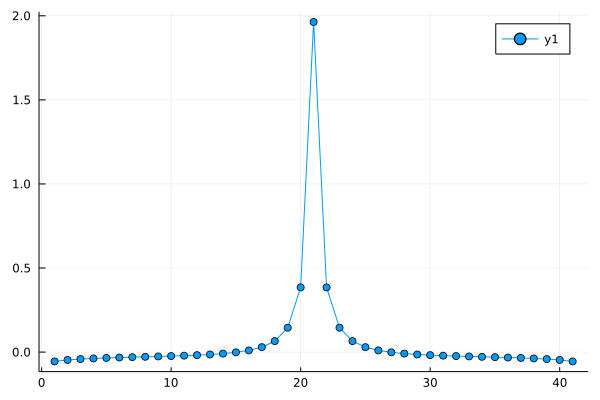

In [5]:
plot(real(locQ_sp.χ),markershape=:circle)

In [6]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [7]:
plot(real.(LadderDGA.kintegrate(qG,nlQ_sp_nλ.χ,dim=2)),markershape=:circle)

LoadError: UndefVarError: nlQ_sp_nλ not defined

In [8]:
locQ_ch.usable_ω

16:26

In [9]:
nlQ_ch_nλ.usable_ω

LoadError: UndefVarError: nlQ_ch_nλ not defined

In [10]:
# non local quantities 
bubble2 = calc_bubble(νGrid2, GLoc_fft2, qG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, qG, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, qG, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);

In [11]:
nlQ_sp_nλ = deepcopy(nlQ_sp)
nlQ_ch_nλ = deepcopy(nlQ_ch)
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
└ χch sum = 0.09156755883093241, rhs = 0.27082184289677275
┌ Info: found 
│   χ_min = -0.0923459536389228
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.0923459536389228, 1.846919072778456]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.02705260062919633
┌ Info: Found λsp 
└   λsp_old = 0.02705260061584617
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(0.02705260061584617, [0.0, 0.0], [-0.0923459536389228, 1.846919072778456], [-Inf, Inf])

In [12]:
nlQ_sp2_nλ = deepcopy(nlQ_sp2)
nlQ_ch2_nλ = deepcopy(nlQ_ch2)
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, qG, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
└ χch sum = 0.09172594174512728, rhs = 0.40827405825487273
┌ Info: found 
│   χ_min = -0.09234595363898714
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.09234595363898714, 1.8469190727797427]"
┌ Info: Method 2 root:
└   r2 = Float64[]
┌ Info: Found λsp 
└   λsp_old = -0.09113681522706829
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(-0.09113681522706829, [0.0, 0.0], [-0.09234595363898714, 1.8469190727797427], [-Inf, Inf])

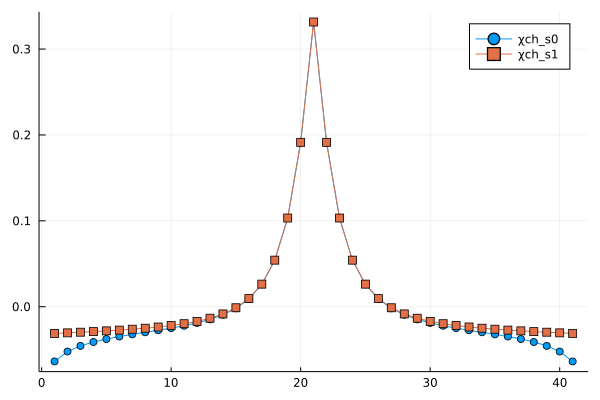

In [13]:
plot(real(LadderDGA.kintegrate(qG, nlQ_ch_nλ.χ, dim=2)[:,1]),markershape=:circle, label="χch_s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_ch2_nλ.χ, dim=2)[:,1]),markershape=:square, label="χch_s1")

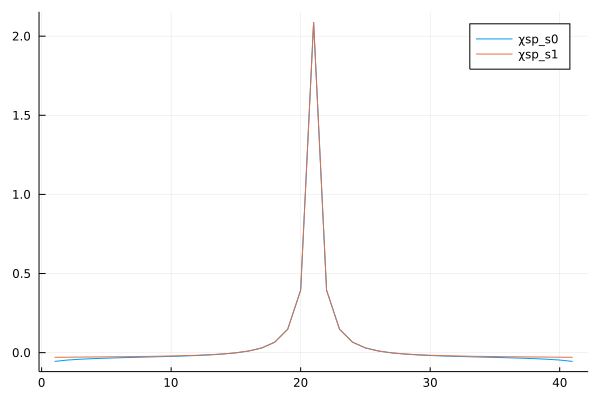

In [14]:
plot(real(LadderDGA.kintegrate(qG, nlQ_sp_nλ.χ, dim=2)[:,1]), label="χsp_s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_sp2_nλ.χ, dim=2)[:,1]), label="χsp_s1")

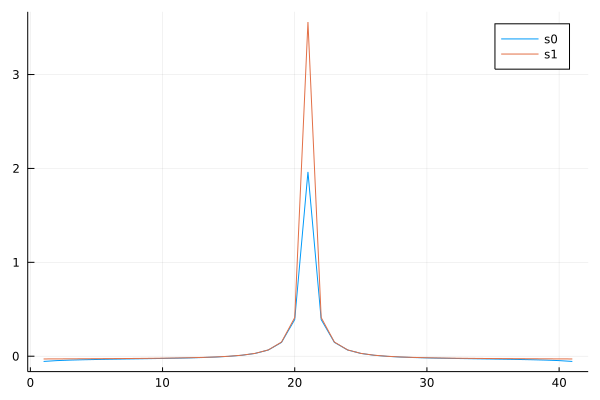

In [15]:
plot(real(LadderDGA.kintegrate(qG, nlQ_sp.χ, dim=2)[:,1]), label="s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_sp2.χ, dim=2)[:,1]), label="s1")

# Investigation of Tail Fits in Σ(ω)

In [32]:
Σ_ladder,tmp,Σ_ladder_nc = calc_Σ(nlQ_sp_nλ, nlQ_ch_nλ, bubble, GLoc_fft, FUpDo, qG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)]
Σ_ladder_corrected_nc = Σ_ladder_nc .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)]


Σ_ladder2,tmp,Σ_ladder_nc2 = calc_Σ(nlQ_sp2_nλ, nlQ_ch2_nλ, bubble2, GLoc_fft2, FUpDo, qG, sumHelper_f2, mP2, sP2)
Σ_ladder_corrected2 = Σ_ladder2 .- Σ_ladderLoc2 .+ Σ_loc[1:size(Σ_ladder2,1)];
Σ_ladder_corrected_nc2 = Σ_ladder_nc2 .- Σ_ladderLoc2 .+ Σ_loc[1:size(Σ_ladder2,1)];

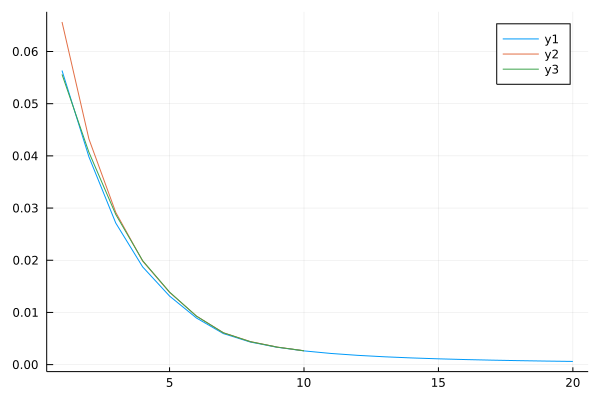

In [48]:
#plot(real(Σ_ladder[:,end]))
#plot!(real(Σ_ladder2[:,end]))
plot(real(Σ_ladder_corrected[:,end]))
plot!(real(Σ_ladder_corrected2[:,end]))
plot!(real(Σ_ladder_corrected_nc2[:,end]))

In [45]:
Σ_ladder_corrected2[:,10]

10-element Vector{ComplexF64}:
   -0.02607348482957017 - 0.131052659254768im
  -0.014902858935245067 - 0.1475643052580143im
   -0.00951912391793408 - 0.12962848649924916im
  -0.006322330158434919 - 0.11007748713870287im
   -0.00436358338084103 - 0.09392686006927851im
 -0.0029134343536308394 - 0.08119460604362952im
  -0.001907597612392009 - 0.07115596802790444im
 -0.0013764987710778165 - 0.06314685305532322im
 -0.0010459497148351815 - 0.056656963118901976im
 -0.0008246788601917188 - 0.05131353932711437im

In [46]:
Σ_ladder_corrected_nc2[:,10]

10-element Vector{ComplexF64}:
   -0.02208028820584662 - 0.13462245542402554im
  -0.014027980339889223 - 0.16102166738740584im
  -0.009388507322685813 - 0.15187621412617347im
  -0.006347116883048509 - 0.12766844962262244im
  -0.004379948073873041 - 0.09534608454687635im
 -0.0029090496885907924 - 0.08597824310286692im
 -0.0019035546651567925 - 0.07464075092637082im
 -0.0013708275194195263 - 0.06515593255867047im
 -0.0010423894876711026 - 0.0569870089906998im
 -0.0008229655697682969 - 0.05124050374983548im

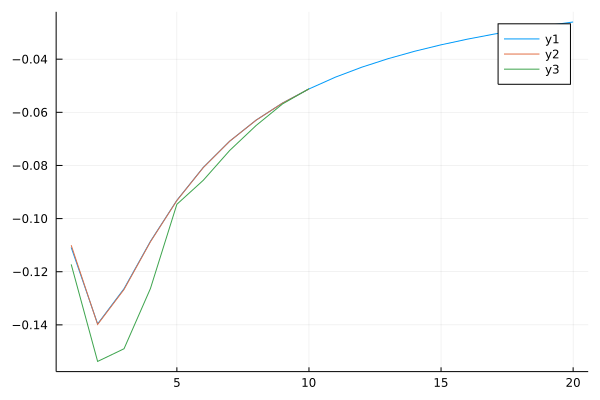

In [51]:
#plot(imag(Σ_ladder[:,end]))
plot(imag(Σ_ladder_corrected[:,end]))
plot!(imag(Σ_ladder_corrected2[:,end]))
plot!(imag(Σ_ladder_corrected_nc2[:,end]))

In [20]:
Σ_ladder

20×56 Matrix{ComplexF64}:
   -0.0563502-0.11889im    …    0.0563502-0.11889im
   -0.0398237-0.149394im        0.0398237-0.149394im
   -0.0271208-0.135623im        0.0271208-0.135623im
    -0.018719-0.117608im         0.018719-0.117608im
   -0.0131351-0.103114im        0.0131351-0.103114im
  -0.00893117-0.09298im    …   0.00893117-0.09298im
  -0.00594523-0.0797611im      0.00594523-0.0797611im
  -0.00433142-0.0706313im      0.00433142-0.0706313im
  -0.00331797-0.0633247im      0.00331796-0.0633247im
  -0.00263068-0.0573im         0.00263068-0.0573im
  -0.00214015-0.0522627im  …   0.00214015-0.0522627im
  -0.00177665-0.0480028im      0.00177665-0.0480028im
  -0.00149929-0.0443624im      0.00149928-0.0443624im
  -0.00128259-0.0412213im      0.00128259-0.0412213im
  -0.00110994-0.0384872im      0.00110994-0.0384872im
 -0.000970101-0.0360889im  …  0.000970097-0.0360889im
 -0.000855205-0.0339686im     0.000855209-0.0339686im
 -0.000759643-0.0320807im      0.00075964-0.0320807im
 -0.000679285

In [21]:
Σ_ladder_corrected[:,end]

20-element Vector{ComplexF64}:
   0.05635017200517184 - 0.1108439955964631im
   0.03982368163704508 - 0.13962721208305498im
   0.02712080156179031 - 0.1263746963863694im
  0.018718961385638166 - 0.10854720815634612im
  0.013135067705418502 - 0.0931170518222266im
   0.00893117306529273 - 0.08073380879453146im
  0.005945231172808374 - 0.07084839724856853im
 0.0043314162453803595 - 0.0629364965341519im
 0.0033179640484679584 - 0.05650663700004672im
 0.0026306758855966783 - 0.05120328925686493im
 0.0021401525854339853 - 0.04676867439751201im
 0.0017766518246236651 - 0.04301400115398725im
  0.001499285541227413 - 0.039799231965006336im
 0.0012825872557732931 - 0.037019022979155145im
  0.001109941481738097 - 0.03459299328425995im
 0.0009700989549135675 - 0.03245896024123359im
 0.0008552073008544214 - 0.030568191893841024im
 0.0007596410883931037 - 0.02888203242020626im
  0.000679283667685826 - 0.027369471941945226im
 0.0006110617376245409 - 0.02600537592638736im

In [22]:
Σ_ladder[:,end]

20-element Vector{ComplexF64}:
   0.05635017241814183 - 0.11889011508117796im
  0.039823678502021266 - 0.14939402023952664im
  0.027120796100836772 - 0.13562345012144625im
   0.01871896001510419 - 0.11760801085604189im
    0.0131350662087553 - 0.10311389583188586im
  0.008931173003120012 - 0.09297996634576088im
  0.005945230184548786 - 0.07976105375098713im
  0.004331415770730244 - 0.07063133980278262im
  0.003317961083551365 - 0.0633246795990748im
  0.002630676003507174 - 0.057299955237861126im
  0.002140151889698363 - 0.05226270069946493im
 0.0017766510122591043 - 0.04800283841785447im
 0.0014992847640694959 - 0.044362432141342945im
 0.0012825874844575595 - 0.041221268003107985im
 0.0011099407331347253 - 0.03848718842644166im
 0.0009700973053801057 - 0.03608891767670188im
 0.0008552088271222267 - 0.033968612157011864im
 0.0007596396004331288 - 0.03208065604927661im
 0.0006792822490689091 - 0.030388148723175943im
 0.0006110616460164606 - 0.028857824593625212im

In [23]:
0.5 .* (impQ_sp.Γ[21,1,:] .+ impQ_ch.Γ[21,1,:])

40-element Vector{ComplexF64}:
     0.00838807234283312 - 1.8408088930418183e-9im
    0.002084736388092219 + 1.3828071353751612e-8im
   0.0008959676799404192 + 1.024820096291227e-8im
   0.0004324929314286361 + 5.972740418589526e-9im
  0.00020395174837737912 + 8.812388219965315e-9im
    7.605241537898995e-5 + 8.322501194104423e-9im
  -1.8432459989742994e-6 + 5.45891588429889e-9im
   -5.240919648277602e-5 + 9.903666786098457e-9im
   -8.680822949235683e-5 + 7.248172948330744e-9im
 -0.00011122801417696353 + 8.065057519170476e-9im
 -0.00012903624671420713 + 9.358552189093795e-9im
  -0.0001423386522372309 + 4.99814008479091e-9im
 -0.00015250701676741956 + 6.74436460087093e-9im
                         ⋮
  -0.0002016612930351683 + 1.8022318840274274e-10im
  -0.0002022083989681664 + 6.28798836991161e-10im
 -0.00020274027416451994 + 4.1737454636030426e-10im
  -0.0002032763274423719 + 1.0425470758665345e-9im
 -0.00020383773095236082 + 1.8129732784674566e-10im
  -0.0002044582950806069 + 1.6438569

In [24]:
Σ_ladder_corrected[:,end]

20-element Vector{ComplexF64}:
   0.05635017200517184 - 0.1108439955964631im
   0.03982368163704508 - 0.13962721208305498im
   0.02712080156179031 - 0.1263746963863694im
  0.018718961385638166 - 0.10854720815634612im
  0.013135067705418502 - 0.0931170518222266im
   0.00893117306529273 - 0.08073380879453146im
  0.005945231172808374 - 0.07084839724856853im
 0.0043314162453803595 - 0.0629364965341519im
 0.0033179640484679584 - 0.05650663700004672im
 0.0026306758855966783 - 0.05120328925686493im
 0.0021401525854339853 - 0.04676867439751201im
 0.0017766518246236651 - 0.04301400115398725im
  0.001499285541227413 - 0.039799231965006336im
 0.0012825872557732931 - 0.037019022979155145im
  0.001109941481738097 - 0.03459299328425995im
 0.0009700989549135675 - 0.03245896024123359im
 0.0008552073008544214 - 0.030568191893841024im
 0.0007596410883931037 - 0.02888203242020626im
  0.000679283667685826 - 0.027369471941945226im
 0.0006110617376245409 - 0.02600537592638736im

In [25]:
nlQ_sp_nλ.χ[21,:]

56-element Vector{ComplexF64}:
 1.2544941211641318 + 3.2738077168506015e-10im
 1.2811924266899553 + 3.661544154557281e-10im
 1.3070776173626915 + 4.034290378875058e-10im
 1.3350128684498337 + 4.4644082203034603e-10im
 1.3551839557021148 + 4.832559092168405e-10im
 1.3840751140336573 + 5.301053393479144e-10im
  1.415538545736486 + 5.847038074613472e-10im
 1.4696514804569298 + 6.872741138669823e-10im
 1.5077873921044342 + 7.645536264811331e-10im
  1.618598802391939 + 1.0150019140547187e-9im
 1.4723610708418908 + 7.178418083443578e-10im
 1.5057710554129484 + 7.823680129722361e-10im
 1.5431618577964006 + 8.604565908866073e-10im
                    ⋮
 2.9659927699095157 + 7.630637232579403e-9im
  1.983539490669088 + 1.9021775512871466e-9im
 2.1151671634262033 + 2.4228536961871926e-9im
 2.5820055671581557 + 4.8065728248388135e-9im
 3.6405183754122796 + 1.3371442259486217e-8im
  5.621356060515166 + 4.1339974468453904e-8im
   1.99313579442099 + 1.8495936979360896e-9im
  2.139679491406543 + 2.43

In [26]:
nlQ_sp.χ[21,:]

56-element Vector{ComplexF64}:
 1.2133173710472764 + 3.0624198986220566e-10im
  1.238274349118083 + 3.4203401876267085e-10im
  1.262438000597211 + 3.763435839707276e-10im
  1.288478724934015 + 4.1586033505493585e-10im
 1.3072582343468861 + 4.496798659634796e-10im
 1.3341218159683401 + 4.925312950449991e-10im
 1.3633311443479397 + 5.423694686967924e-10im
 1.4134554670533612 + 6.357195005681027e-10im
 1.4486957165730467 + 7.058007080443391e-10im
 1.5506979167130783 + 9.31628656229848e-10im
 1.4159616257802434 + 6.639006038199022e-10im
  1.446834229811882 + 7.223218403981189e-10im
 1.4813217960734952 + 7.928751945278713e-10im
                    ⋮
 2.7456849972694743 + 6.539161337194476e-9im
  1.882523466603306 + 1.713366007890948e-9im
  2.000686345207387 + 2.167683215128988e-9im
  2.413427724140651 + 4.199424453256882e-9im
 3.3141251384120354 + 1.1081271721994156e-8im
  4.879343126680052 + 3.11466063687542e-8im
 1.8911651050219669 + 1.6651810174112616e-9im
 2.0226033330045534 + 2.1733063

In [27]:
findmax(abs.(nlQ_ch_sol.χ .- nlQ_ch.χ))

LoadError: UndefVarError: nlQ_ch_sol not defined

In [28]:
nlQ_ch_sol.χ[21,:]

LoadError: UndefVarError: nlQ_ch_sol not defined

In [29]:
nlQ_ch.χ[21,:]

56-element Vector{ComplexF64}:
  0.3071310295182881 - 9.101865238330007e-9im
  0.3085023340336088 - 9.242142734908261e-9im
  0.3097942975305579 - 9.37058867649633e-9im
  0.3111398393241445 - 9.507064541303321e-9im
 0.31207232908691257 - 9.610693330170472e-9im
  0.3133874432620961 - 9.742793353645141e-9im
 0.31476576707661974 - 9.884322016660578e-9im
   0.317016902904007 - 1.0121532387434769e-8im
 0.31851933030834395 - 1.0281964610247857e-8im
 0.32253862265827027 - 1.0721047209330783e-8im
 0.31707171507636517 - 1.0167313863678116e-8im
 0.31839775766704353 - 1.0301887181105698e-8im
 0.31981870268512025 - 1.0450834945503191e-8im
                     ⋮
  0.3490318092053461 - 1.4104695822485894e-8im
   0.333252510961106 - 1.177551207853772e-8im
 0.33616459483371675 - 1.2167182197172807e-8im
 0.34427899537864415 - 1.3312438775146586e-8im
 0.35537477659286865 - 1.5008004427673925e-8im
   0.365284476023976 - 1.664984664668439e-8im
  0.3335862867699871 - 1.1743345472114571e-8im
  0.336773981094

In [30]:
nlQ_sp_sol.χ[21,:]

LoadError: UndefVarError: nlQ_sp_sol not defined

In [31]:
nlQ_sp.χ[21,:]

56-element Vector{ComplexF64}:
 1.2133173710472764 + 3.0624198986220566e-10im
  1.238274349118083 + 3.4203401876267085e-10im
  1.262438000597211 + 3.763435839707276e-10im
  1.288478724934015 + 4.1586033505493585e-10im
 1.3072582343468861 + 4.496798659634796e-10im
 1.3341218159683401 + 4.925312950449991e-10im
 1.3633311443479397 + 5.423694686967924e-10im
 1.4134554670533612 + 6.357195005681027e-10im
 1.4486957165730467 + 7.058007080443391e-10im
 1.5506979167130783 + 9.31628656229848e-10im
 1.4159616257802434 + 6.639006038199022e-10im
  1.446834229811882 + 7.223218403981189e-10im
 1.4813217960734952 + 7.928751945278713e-10im
                    ⋮
 2.7456849972694743 + 6.539161337194476e-9im
  1.882523466603306 + 1.713366007890948e-9im
  2.000686345207387 + 2.167683215128988e-9im
  2.413427724140651 + 4.199424453256882e-9im
 3.3141251384120354 + 1.1081271721994156e-8im
  4.879343126680052 + 3.11466063687542e-8im
 1.8911651050219669 + 1.6651810174112616e-9im
 2.0226033330045534 + 2.1733063